# Getting the fashion MNIST data

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import notebook
import time

plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set to 1 to save figures
# m_path = "/content/drive/MyDrive/NNnotebooks/assignment/models/"
save = 0

In [ ]:
def get_data(batch_size=100, validation_split=0.2):
  # Get the data
  dataset = torchvision.datasets.FashionMNIST(root='data',
                                              train=True,
                                              transform=transforms.ToTensor(),
                                              download=True)

  # Calculate split sizes
  total_size = len(dataset)
  split = int(total_size * validation_split)

  # Split the data into training and validation datasets
  train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [total_size - split, split])

  test_dataset = torchvision.datasets.FashionMNIST(root='data',
                                                   train=False,
                                                   transform=transforms.ToTensor())

  # Data loader
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=batch_size,
                                             shuffle=True)

  validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=False)

  test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)

  return train_loader, validation_loader, test_loader


In [ ]:
train_loader, validation_loader, test_loader = get_data(100)

In [ ]:
# plt.style.use('default')

# # Have a look at the data
# fig, ax = plt.subplots(2, 5, figsize=(8, 4))
# for i in range(10):
#   ax[i % 2, i % 5].imshow(train_dataset[i][0][0], cmap='gray', vmin=0, vmax=1)
# plt.show()

In [ ]:
# Let's create the model - on CPU first.

# Use GPU if supported, cpu otherwise
# device = 'cpu'
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.get_device_name(0))


In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Assuming the input image size is (28, 28), after three layers of Conv2d + MaxPool2d,
        # the output feature map size will be (64, 3, 3), so we flatten it to a vector of length 64*3*3
        self.fc = nn.Linear(3*3*64, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten the output
        out = self.fc(out)

        return out


In [ ]:
# Saving trained models to drive function
# Enter the model name and enter the parameter that is being changed
# def save_model(model_name, param, model, p="/content/drive/MyDrive/NNnotebooks/assignment/models/"):

#     path = p + param + " " + model_name
#     torch.save(model.state_dict(), path)
#     print(f"Model saved at: {path}")


# def load_model(model_name, param, model_class=ConvNet, num_classes=10, p="/content/drive/MyDrive/NNnotebooks/assignment/models/"):

#     model = model_class(num_classes)
#     path = p + param + " " + model_name
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     print(f"Model loaded from: {path}")
#     return model


# def save_all_models(models, param):

#   for name, model in models:
#     save_model(name, param, model=model)


# # Pass param e.g learning_rate and list e.g learning_rate_list
# def load_all_models(param, list_of):

#   list_of_models = []
#   for name, _ in list_of:
#     list_of_models.append((name, load_model(name, param)))
#   return list_of_models


In [ ]:
# Some hyperparameters for Convolutional Neural Network
# (These will be used when a different list is used for a test)
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

# Lists for training and testing different parameters
learning_rate_list = [
    ("LR: 0.01", 0.01),
    ("LR: 0.001", 0.001),
    ("LR: 0.0001", 0.0001)
]

batch_size_list = [
    ("Batch Size: 10", 10),
    ("Batch Size: 100", 100),
    ("Batch Size: 1000", 1000)
]

optimizers_list = [
    ("Adam", torch.optim.Adam),
    ("SGD", torch.optim.SGD),
    ("RMSprop", torch.optim.RMSprop)
]

# This time let's try running the program on GPU!
# device = 'cuda:0'
train_loader, validation_loader, test_loader = get_data(100)


In [ ]:
def train_model(model=ConvNet, learning_rate=0.001, opti=torch.optim.Adam, num_classses=10):
  # And let's initialize the model.
  model = model(num_classes).to(device)
  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = opti(model.parameters(), lr=learning_rate)

  # Train the model!
  total_epochs = notebook.tqdm(range(num_epochs))

  model.train()     # Set the model into `training` mode, because certain operators will perform differently during training and evaluation (e.g. dropout and batch normalization)

  # Initialize a list to hold your loss values at each epoch
  train_loss_values = []
  validation_accuracy = []
  training_data_accuracy = []
  for epoch in total_epochs:
    model.train()
    epoch_loss = 0.0
    num_batches = 0
    for i, (images, labels) in enumerate(train_loader):
      # Move tensors to the configured device

      images = images.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward and optimize
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      epoch_loss += loss.item()
      num_batches += 1
      if (i + 1) % 10 == 0:
        total_epochs.set_description(
            'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))

      # At the end of each epoch, add the current loss to the train_loss_values list
    train_loss_values.append(epoch_loss / num_batches)
    validation_accuracy.append(model_validation(model))
    training_data_accuracy.append(model_train_acc(model))

  return model, train_loss_values, validation_accuracy, training_data_accuracy

# trained_model = train_model()


In [ ]:
# save_model("test", "t", trained_model)

In [ ]:
# loaded_model = load_model("test", "t")

Model validation data accuracy

In [ ]:
def model_validation(model):
  model = model.to(device)
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in notebook.tqdm(validation_loader):

      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the {} validation images: {} %'.format(len(validation_loader) * len(images), 100 * correct / total))
  accuracy = (100 * (correct / total))
  return accuracy

Model training data accuracy

In [ ]:
def model_train_acc(model):
  model = model.to(device)
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in notebook.tqdm(train_loader):

      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the {} training images: {} %'.format(len(train_loader) * len(images), 100 * correct / total))
  accuracy = (100 * (correct / total))
  return accuracy

Model testing data accuracy

In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
def model_testing(model):
  model = model.to(device)
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in notebook.tqdm(test_loader):

      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
  accuracy = (100 * (correct / total))
  return accuracy
# model_testing(trained_model)
# model_testing(loaded_model)

# Learning Rate (0.01, 0.001, 0.0001)

Training learning rate models

In [ ]:
# List of models for each learning rate
learning_rate_models = []
learning_rate_loss_data = []
learning_rate_val_acc = []
learning_rate_train_acc = []
for name, learning_rate in learning_rate_list:
  print(f"Name: {name}, Learning Rate: {learning_rate}")
  m, loss_vals, val_acc, train_acc = train_model(learning_rate=learning_rate)
  learning_rate_models.append((name, m))
  learning_rate_loss_data.append((name, loss_vals))
  learning_rate_val_acc.append((name, val_acc))
  learning_rate_train_acc.append((name, train_acc))

print("Finished training the model")
# save_all_models(learning_rate_models, "learning rate")
print(learning_rate_loss_data)
print(learning_rate_val_acc)
print(learning_rate_train_acc)

Name: LR: 0.01, Learning Rate: 0.01


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 87.14166666666667 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 87.41041666666666 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 88.36666666666666 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 89.325 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 90.34166666666667 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 91.97916666666667 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 90.59166666666667 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 92.6 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 90.51666666666667 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 92.85208333333334 %
Name: LR: 0.001, Learning Rate: 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 86.675 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 87.91666666666667 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 88.375 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 90.2625 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 90.51666666666667 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 92.6 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 90.625 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 93.05416666666666 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 91.1 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 94.21666666666667 %
Name: LR: 0.0001, Learning Rate: 0.0001


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 85.26666666666667 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 86.09791666666666 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 87.975 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 88.9875 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 88.84166666666667 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 89.93958333333333 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 89.125 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 91.03541666666666 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 89.55 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 91.85833333333333 %
Finished training the model
[('LR: 0.01', [0.4838301622929672, 0.3059302918612957, 0.2594807782055189, 0.23398327976465225, 0.21242447981300452]), ('LR: 0.001', [0.4103463036008179, 0.27741285854329667, 0.2412647490389645, 0.2111004056253781, 0.18629615145425002]), ('LR: 0.0001', [0.6407540694500009, 0.36889549853901066, 0.3150031472245852, 0.28395222234539685, 0.26061479062773285])]
[('LR: 0.01', [87.14166666666667, 88.36666666666667, 90.34166666666667, 90.59166666666667, 90.51666666666667]), ('LR: 0.001', [86.675, 88.375, 90.51666666666667, 90.625, 91.10000000000001]), ('LR: 0.0001', [85.26666666666667, 87.97500000000001, 88.84166666666667, 89.125, 89.55])]
[('LR: 0.01', [87.41041666666666, 89.325, 91.97916666666667, 92.60000000000001, 92.85208333333334]), ('LR: 0.001', [87.91666666666667, 90.2625, 92.60000000000001, 93.05416666666667, 94.21666666666667]), ('LR: 0.0001', [86.09791666666666, 88.9875, 89.93958333

Loss curve for learning rate

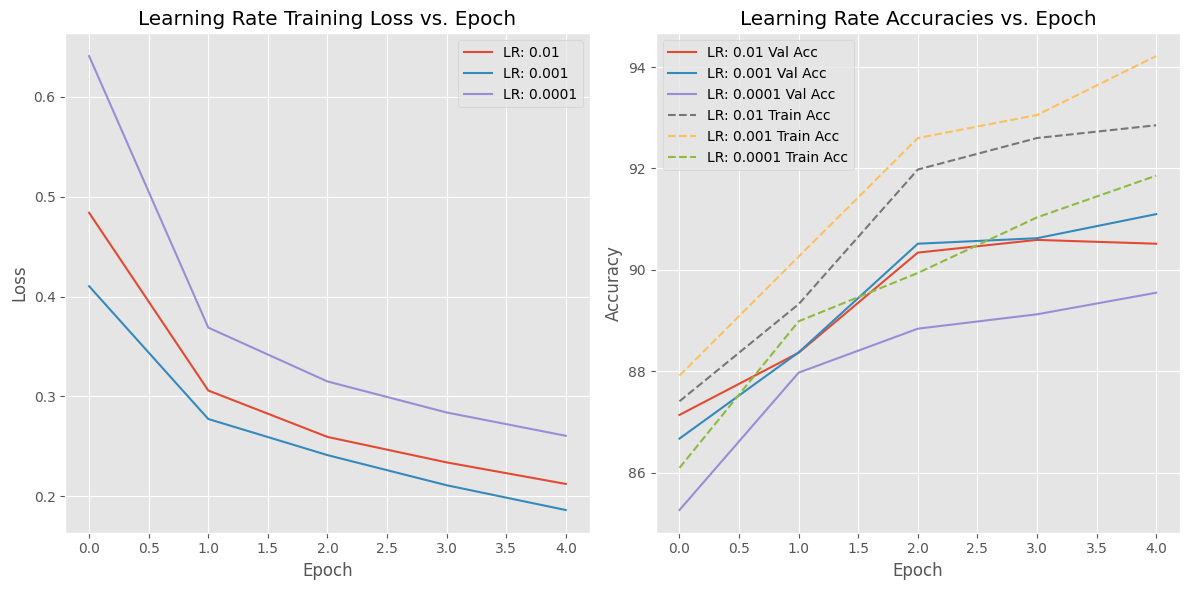

In [ ]:
def show_loss_curve_and_val_acc(rate_loss, val_acc_data, train_acc_data, hparam, save_path=save):
    # Initialize a figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Loop through all loss data and plot each one
    for name, loss_vals in rate_loss:
        ax1.plot(loss_vals, label=f'{name}')
    ax1.set_title(hparam + " Training Loss vs. Epoch")
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Loop through all validation and training accuracy data and plot each one
    for name, val_acc in val_acc_data:
        ax2.plot(val_acc, label=f'{name} Val Acc')
    for name, train_acc in train_acc_data:
        ax2.plot(train_acc, label=f'{name} Train Acc', linestyle='--')
    ax2.set_title(hparam + " Accuracies vs. Epoch")
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Save the plot
    if save_path == 1:
        path = "/content/drive/MyDrive/NNnotebooks/assignment/models/" + hparam + "loss_val.jpeg"
        plt.savefig(path)

    # Show the plot
    plt.tight_layout()  # adjusts subplot params so that subplots are nicely fit in the figure
    plt.show()

show_loss_curve_and_val_acc(learning_rate_loss_data, learning_rate_val_acc, learning_rate_train_acc, "Learning Rate")


In [ ]:
# import json

# def save_json(name, data):
#   # Save the data to a json file
#   path = "/content/drive/MyDrive/NNnotebooks/assignment/models/" + name + ".json"
#   with open(path, 'w') as f:
#       json.dump(data, f)

# save_json("learning_rate_loss_data", learning_rate_loss_data)
# save_json("learning_rate_val_acc_data", learning_rate_val_acc)

# def load_json(name):
#   path = "/content/drive/MyDrive/NNnotebooks/assignment/models/" + name + ".json"
#   with open(path, 'r') as f:
#       loaded_data = json.load(f)

#   loaded_data = [(name, loss_vals) for name, loss_vals in loaded_data]
#   return loaded_data

# learning_rate_loss_data = load_json("learning_rate_loss_data")
# learning_rate_val_acc = load_json("learning_rate_val_acc_data")


In [ ]:
print(learning_rate_loss_data)

[('LR: 0.01', [0.4838301622929672, 0.3059302918612957, 0.2594807782055189, 0.23398327976465225, 0.21242447981300452]), ('LR: 0.001', [0.4103463036008179, 0.27741285854329667, 0.2412647490389645, 0.2111004056253781, 0.18629615145425002]), ('LR: 0.0001', [0.6407540694500009, 0.36889549853901066, 0.3150031472245852, 0.28395222234539685, 0.26061479062773285])]


Saving the learning rate models to a file (this happens after training)

In [ ]:
# save_all_models(learning_rate_models, "learning rate")

Loading all the learning rate models from file

In [ ]:
# learning_rate_models = load_all_models("learning rate", learning_rate_list)
print(len(learning_rate_models))

3


In [ ]:
learning_rate_testing_acc = []
for name, model in learning_rate_models:
  print(name)

  learning_rate_testing_acc.append((name, model_testing(model)))
# save_json("learning_rate_testing_acc", learning_rate_testing_acc)

print(learning_rate_testing_acc)

LR: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 89.76 %
LR: 0.001


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 90.38 %
LR: 0.0001


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 89.16 %
[('LR: 0.01', 89.75999999999999), ('LR: 0.001', 90.38000000000001), ('LR: 0.0001', 89.16)]


In [ ]:
# learning_rate_testing_acc = load_json("learning_rate_testing_acc")

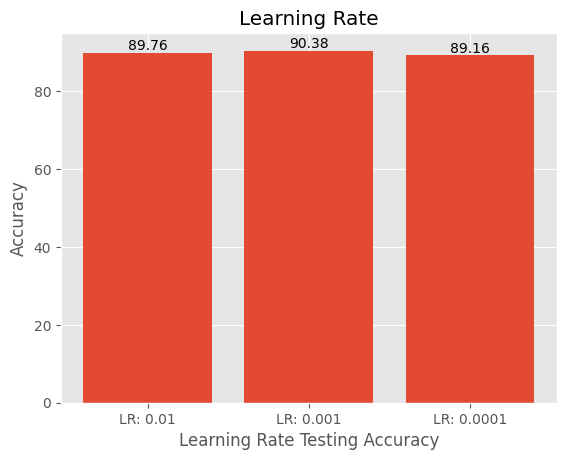

In [ ]:
import matplotlib.pyplot as plt

def plot_bar_chart(data, title="Model Accuracy", xlabel="Model", ylabel="Accuracy", save_path=save):
    # Get the names and accuracies
    names = [x[0] for x in data]
    accuracies = [x[1] for x in data]

    # Create a bar chart
    plt.bar(names, accuracies)
    xlabel = xlabel + " Testing Accuracy"
    # Add title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Show the actual values above each bar
    for i in range(len(accuracies)):
        plt.text(x=i, y=accuracies[i], s=round(accuracies[i], 2), ha='center', va='bottom')

    if save_path == 1:
        path = "/content/drive/MyDrive/NNnotebooks/assignment/models/" + title + "test_acc.jpeg"
        plt.savefig(path)
    # Show the plot
    plt.show()

plot_bar_chart(learning_rate_testing_acc, title="Learning Rate", xlabel="Learning Rate")


# Different Batch Sizes (10, 100, 1000)

In [ ]:
# List of models for each batch size
batch_size_models = []
batch_size_loss_data = []
batch_size_val_acc = []
batch_size_train_acc = []
for name, x in batch_size_list:
  print(f"Name: {name}, Batch Size: {x}")
  train_loader, validation_loader, test_loader = get_data(x)
  m, loss_vals, val_acc, train_acc = train_model()
  batch_size_models.append((name, m))
  batch_size_loss_data.append((name, loss_vals))
  batch_size_val_acc.append((name, val_acc))
  batch_size_train_acc.append((name, train_acc))

print("Finished training the model")
# save_all_models(batch_size_models, "batch size")
print(batch_size_loss_data)
print(batch_size_val_acc)
print(batch_size_train_acc)

Name: Batch Size: 10, Batch Size: 10


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 89.3 %


  0%|          | 0/4800 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 89.90625 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 89.575 %


  0%|          | 0/4800 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 91.48333333333333 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 90.56666666666666 %


  0%|          | 0/4800 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 92.95625 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 91.775 %


  0%|          | 0/4800 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 94.64375 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 91.7 %


  0%|          | 0/4800 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 95.22708333333334 %
Name: Batch Size: 100, Batch Size: 100


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 88.8 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 89.82291666666667 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 89.04166666666667 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 91.21666666666667 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 90.13333333333334 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 92.14583333333333 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 91.15 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 93.79791666666667 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 91.35 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 94.75625 %
Name: Batch Size: 1000, Batch Size: 1000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 83.85 %


  0%|          | 0/48 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 84.51458333333333 %


  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 88.68333333333334 %


  0%|          | 0/48 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 88.95 %


  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 89.76666666666667 %


  0%|          | 0/48 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 90.41666666666667 %


  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 90.28333333333333 %


  0%|          | 0/48 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 91.32083333333334 %


  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 90.38333333333334 %


  0%|          | 0/48 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 91.94166666666666 %
Finished training the model
[('Batch Size: 10', [0.38579858778005777, 0.2729246037597962, 0.23236357925838091, 0.20281048398373058, 0.17553696959140933]), ('Batch Size: 100', [0.41772947755331796, 0.27881033526112636, 0.23839879153917234, 0.20981800629136463, 0.18419150623182456]), ('Batch Size: 1000', [0.6451293441156546, 0.35255663593610126, 0.29369373495380086, 0.2584218631188075, 0.23435658340652785])]
[('Batch Size: 10', [89.3, 89.575, 90.56666666666666, 91.77499999999999, 91.7]), ('Batch Size: 100', [88.8, 89.04166666666666, 90.13333333333333, 91.14999999999999, 91.35]), ('Batch Size: 1000', [83.85000000000001, 88.68333333333334, 89.76666666666667, 90.28333333333333, 90.38333333333334])]
[('Batch Size: 10', [89.90625, 91.48333333333333, 92.95625, 94.64375000000001, 95.22708333333333]), ('Batch Size: 100', [89.82291666666666, 91.21666666666667, 92.14583333333334, 93.79791666666667, 94.75625]), ('Batch Size: 

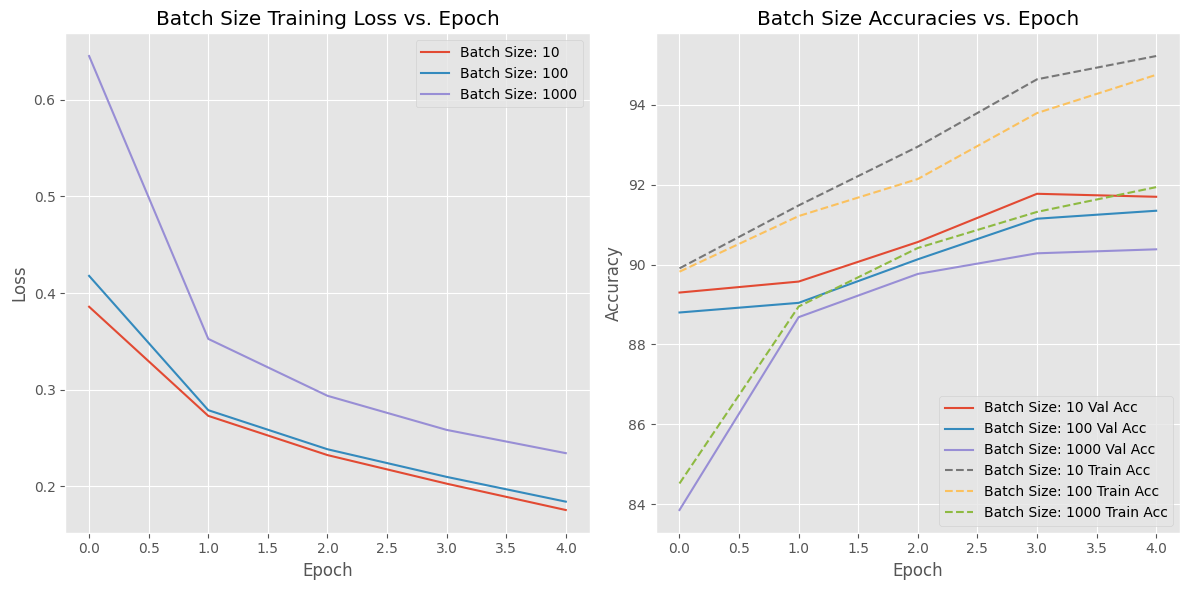

In [ ]:

show_loss_curve_and_val_acc(batch_size_loss_data, batch_size_val_acc, batch_size_train_acc, "Batch Size")


In [ ]:
# batch_size_models = load_all_models("batch size", batch_size_list)
print(len(batch_size_models))

3


In [ ]:
# save_json("batch_size_loss_data", batch_size_loss_data)
# save_json("batch_size_val_acc_data", batch_size_val_acc)

In [ ]:
# batch_size_loss_data = load_json("batch_size_loss_data")
# batch_size_val_acc = load_json("batch_size_val_acc_data")

In [ ]:
# Setting the batch size to 100
train_loader, validation_loader, test_loader = get_data(100)
batch_size_testing_acc = []
for name, model in batch_size_models:
  print(name)

  batch_size_testing_acc.append((name, model_testing(model)))
#save_json("batch_size_testing_acc", batch_size_testing_acc)

print(batch_size_testing_acc)

Batch Size: 10


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 91.38 %
Batch Size: 100


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 90.67 %
Batch Size: 1000


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 89.2 %
[('Batch Size: 10', 91.38), ('Batch Size: 100', 90.67), ('Batch Size: 1000', 89.2)]


In [ ]:
# batch_size_testing_acc = load_json("batch_size_testing_acc")

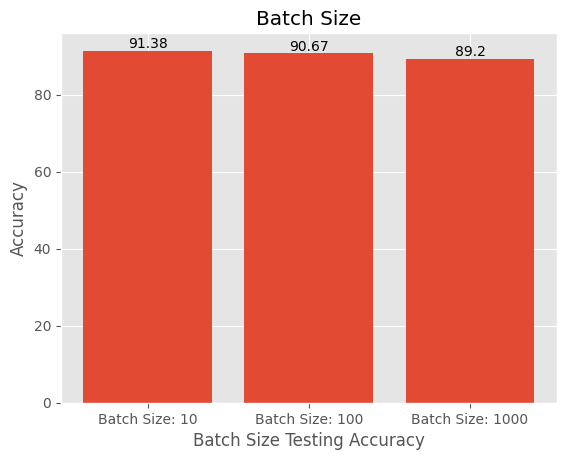

In [ ]:
plot_bar_chart(batch_size_testing_acc, title="Batch Size", xlabel="Batch Size")


# Different Optimizers (SGD, Adam, RMSProp)

In [ ]:
# List of models for each optimizer
optimizer_models = []
optimizer_loss_data = []
optimizer_val_acc = []
optimizer_train_acc = []
for name, x in optimizers_list:
  print(f"Name: {name}, Optimizer: {x}")
  m, loss_vals, val_acc, train_acc = train_model()
  optimizer_models.append((name, m))
  optimizer_loss_data.append((name, loss_vals))
  optimizer_val_acc.append((name, val_acc))
  optimizer_train_acc.append((name, train_acc))

print("Finished training the model")
# save_all_models(optimizer_models, "optimizer")
print(optimizer_loss_data)
print(optimizer_val_acc)
print(optimizer_train_acc)

Name: Adam, Optimizer: <class 'torch.optim.adam.Adam'>


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 87.25 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 88.42916666666666 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 89.96666666666667 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 91.39166666666667 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 89.59166666666667 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 91.65625 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 91.11666666666666 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 94.03125 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 89.39166666666667 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 92.325 %
Name: SGD, Optimizer: <class 'torch.optim.sgd.SGD'>


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 86.225 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 86.78125 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 90.00833333333334 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 91.84166666666667 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 89.64166666666667 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 91.45208333333333 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 90.23333333333333 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 92.85833333333333 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 90.03333333333333 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 92.48958333333333 %
Name: RMSprop, Optimizer: <class 'torch.optim.rmsprop.RMSprop'>


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 88.79166666666667 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 89.66041666666666 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 89.69166666666666 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 91.35 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 89.89166666666667 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 91.84166666666667 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 90.23333333333333 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 92.81458333333333 %


  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 12000 validation images: 90.30833333333334 %


  0%|          | 0/480 [00:00<?, ?it/s]

Accuracy of the network on the 48000 training images: 93.08125 %
Finished training the model
[('Adam', [0.4144782287068665, 0.2829592840435604, 0.23922627065330743, 0.21323203118517994, 0.18570620405177277]), ('SGD', [0.4140166019710402, 0.2796625813934952, 0.23927416351313394, 0.2068317221943289, 0.18567041514907032]), ('RMSprop', [0.4098485876185199, 0.2795061705323557, 0.23791734923919042, 0.2104620251338929, 0.18912717723287642])]
[('Adam', [87.25, 89.96666666666667, 89.59166666666667, 91.11666666666667, 89.39166666666667]), ('SGD', [86.225, 90.00833333333334, 89.64166666666667, 90.23333333333333, 90.03333333333333]), ('RMSprop', [88.79166666666667, 89.69166666666666, 89.89166666666667, 90.23333333333333, 90.30833333333334])]
[('Adam', [88.42916666666667, 91.39166666666667, 91.65625, 94.03125, 92.325]), ('SGD', [86.78125, 91.84166666666667, 91.45208333333333, 92.85833333333333, 92.48958333333334]), ('RMSprop', [89.66041666666666, 91.35, 91.84166666666667, 92.81458333333333, 93.0812

In [ ]:
# optimizer_models = load_all_models("optimizer", optimizers_list)
print(len(optimizer_models))

3


In [ ]:
# save_json("optimizer_loss_data", optimizer_loss_data)
# save_json("optimizer_val_acc_data", optimizer_val_acc)

In [ ]:
# optimizer_loss_data = load_json("optimizer_loss_data")
# optimizer_val_acc = load_json("optimizer_val_acc_data")

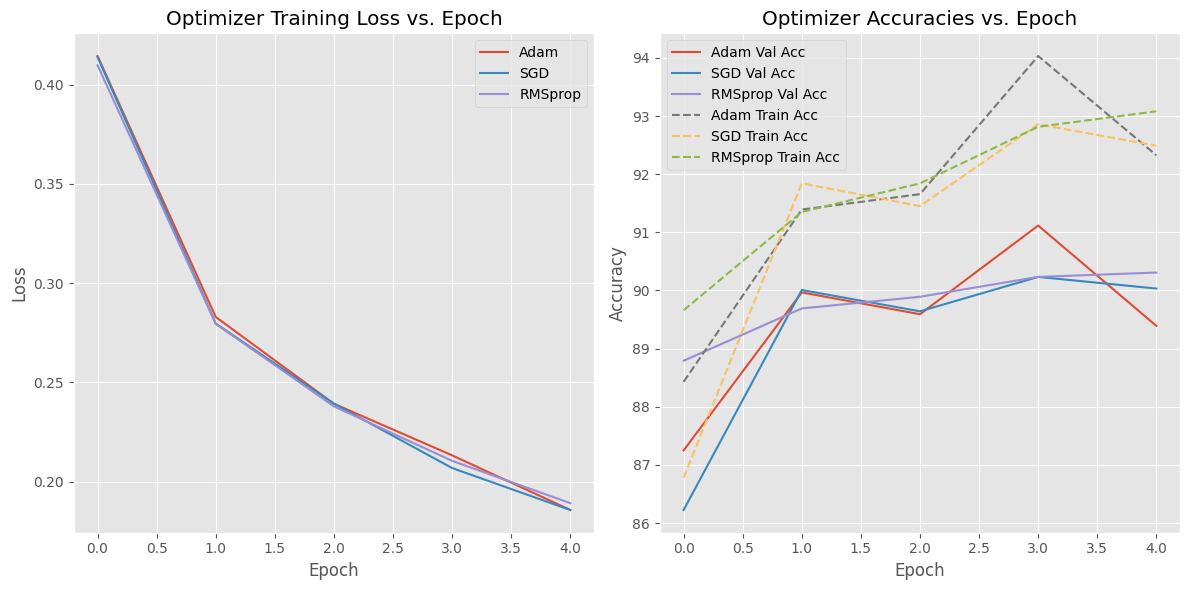

In [ ]:
show_loss_curve_and_val_acc(optimizer_loss_data, optimizer_val_acc, optimizer_train_acc, "Optimizer")


In [ ]:
optimizer_testing_acc = []
for name, model in optimizer_models:
  print(name)

  optimizer_testing_acc.append((name, model_testing(model)))
# save_json("optimizer_testing_acc", optimizer_testing_acc)

print(optimizer_testing_acc)

Adam


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.69 %
SGD


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 89.57 %
RMSprop


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 89.78 %
[('Adam', 88.69), ('SGD', 89.57000000000001), ('RMSprop', 89.78)]


In [ ]:
# optimizer_testing_acc = load_json("optimizer_testing_acc")

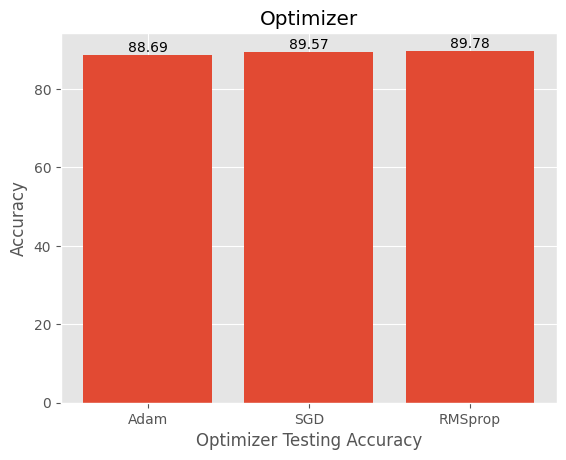

In [ ]:
plot_bar_chart(optimizer_testing_acc, title="Optimizer", xlabel="Optimizer")


# Resnet-18

In [ ]:
import torchvision.models as models
train_loader, validation_loader, test_loader = get_data(100)
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

NameError: ignored

In [ ]:
class ResNet18Modified(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Identity()  # remove the final fc layer

    def forward(self, x):
        x = self.model(x)
        return x

print(ResNet18Modified)

<class '__main__.ResNet18Modified'>


In [ ]:


def get_data2(batch_size=100, validation_split=0.2):
  # Get the data
  data_transforms = {
    # 'train': transforms.Compose([
    #     #transforms.Resize(28),
    #     transforms.RandomHorizontalFlip(),
    #     transforms.Grayscale(3),
    #     transforms.ToTensor(),
    #     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    # ]),
    'test': transforms.Compose([
        #transforms.Resize(28),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
  }
  dataset = torchvision.datasets.FashionMNIST(root='data',
                                              train=True,
                                              transform=transforms.ToTensor(),
                                              download=True)

  # Calculate split sizes
  total_size = len(dataset)
  split = int(total_size * validation_split)

  # Split the data into training and validation datasets
  train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [total_size - split, split])

  test_dataset = torchvision.datasets.FashionMNIST(root='data',
                                                   train=False,
                                                   transform=data_transforms['test'])

  # Data loader
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=batch_size,
                                             shuffle=True)

  validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=False)

  test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)

  return train_loader, validation_loader, test_loader


In [ ]:
class ConvNetR(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Linear(3*3*64, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        hidden_out = out.view(out.size(0), -1)  # Flatten the output
        final_out = self.fc(hidden_out)

        return final_out, hidden_out


In [ ]:
from torch.utils.data import DataLoader
def get_subset(test_loader):
  subset = []
  class_counts = [0]*10

  for images, labels in test_loader:
    for img, lbl in zip(images, labels):
      if class_counts[lbl] < 100:
        subset.append((img, lbl))
        # Increment count for lbl
        class_counts[lbl] += 1
        # Stop if there are 100 images in each class
        if all(count == 100 for count in class_counts):
          return subset

  return subset


tr_loader, val_loader, t_loader = get_data2(100)
print(t_loader)
subset = get_subset(t_loader)

subset.sort(key=lambda x: x[1])


subset_loader = DataLoader(subset, batch_size=100, shuffle=False)
print((subset[999]))
print(subset_loader)

(tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -0.9922, -0.9922,  ..., -0.4824, -0.6863, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -0.9922, -0.9922,  ..., -0.4824, -0.6863, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -

In [ ]:
import numpy as np

tr_loader, val_loader, t_loader = get_data2(10)
# Initialize your model
# model = ConvNetR(num_classes=10)
model = ResNet18Modified()
model = model.to(device)
model.eval()



representations = [[] for _ in range(10)]

for images, labels in subset_loader:
  images = images.to(device)
  labels = labels.to(device)
  output = model(images)
  output = output.detach().cpu().numpy()


  for img, lbl in zip(output, labels):

    representations[lbl.item()].append(img)




mean_rep = [np.mean(rep, axis=0) for rep in representations]
correlation_matrix = np.corrcoef(mean_rep)


correlation_matrix

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


array([[1.        , 0.83475118, 0.89323702, 0.92296383, 0.89011401,
        0.4962132 , 0.9550009 , 0.51382206, 0.86315131, 0.60248202],
       [0.83475118, 1.        , 0.77303177, 0.87819888, 0.77159431,
        0.43684592, 0.82081335, 0.44398494, 0.7114715 , 0.5156918 ],
       [0.89323702, 0.77303177, 1.        , 0.77881641, 0.92574753,
        0.39068369, 0.92535265, 0.40822262, 0.82064587, 0.46062612],
       [0.92296383, 0.87819888, 0.77881641, 1.        , 0.81670604,
        0.59506897, 0.90782344, 0.54807661, 0.81367251, 0.61318767],
       [0.89011401, 0.77159431, 0.92574753, 0.81670604, 1.        ,
        0.32332138, 0.92439555, 0.41670054, 0.76051067, 0.49786134],
       [0.4962132 , 0.43684592, 0.39068369, 0.59506897, 0.32332138,
        1.        , 0.50269503, 0.78995989, 0.71194319, 0.6264608 ],
       [0.9550009 , 0.82081335, 0.92535265, 0.90782344, 0.92439555,
        0.50269503, 1.        , 0.50967315, 0.86974252, 0.57346003],
       [0.51382206, 0.44398494, 0.4082226

          0         1         2         3         4         5         6  \
0  1.000000  0.834751  0.893237  0.922964  0.890114  0.496213  0.955001   
1  0.834751  1.000000  0.773032  0.878199  0.771594  0.436846  0.820813   
2  0.893237  0.773032  1.000000  0.778816  0.925748  0.390684  0.925353   
3  0.922964  0.878199  0.778816  1.000000  0.816706  0.595069  0.907823   
4  0.890114  0.771594  0.925748  0.816706  1.000000  0.323321  0.924396   
5  0.496213  0.436846  0.390684  0.595069  0.323321  1.000000  0.502695   
6  0.955001  0.820813  0.925353  0.907823  0.924396  0.502695  1.000000   
7  0.513822  0.443985  0.408223  0.548077  0.416701  0.789960  0.509673   
8  0.863151  0.711471  0.820646  0.813673  0.760511  0.711943  0.869743   
9  0.602482  0.515692  0.460626  0.613188  0.497861  0.626461  0.573460   

          7         8         9  
0  0.513822  0.863151  0.602482  
1  0.443985  0.711471  0.515692  
2  0.408223  0.820646  0.460626  
3  0.548077  0.813673  0.613188  
4  0

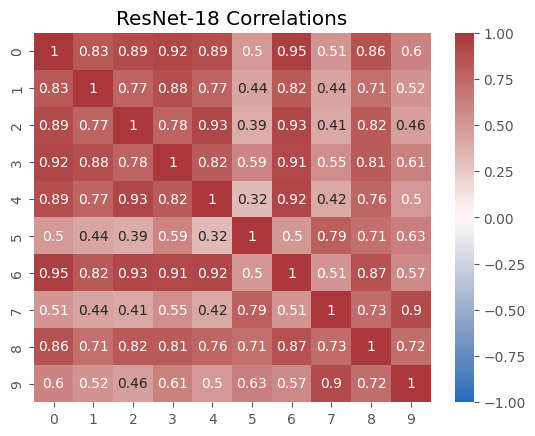

In [ ]:
import pandas as pd
import seaborn as sns
# Create a pandas DataFrame from the correlation matrix
df = pd.DataFrame(correlation_matrix)

df.columns = range(10)
df.index = range(10)

sns.heatmap(df.round(3), annot=True, vmin=-1, vmax=1, cmap='vlag')
plt.title('ResNet-18 Correlations')

# Save the plot
if save == 1:
    path = "/content/drive/MyDrive/NNnotebooks/assignment/models/resnet-18 correlation.jpeg"
    plt.savefig(path)
# Display the DataFrame
print(df)


In [ ]:
def train_model2(model=ConvNet, learning_rate=0.001, opti=torch.optim.Adam, num_classses=10):
  # And let's initialize the model.
  model = model(num_classes).to(device)
  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = opti(model.parameters(), lr=learning_rate)

  # Train the model!
  total_epochs = notebook.tqdm(range(num_epochs))

  model.train()     # Set the model into `training` mode, because certain operators will perform differently during training and evaluation (e.g. dropout and batch normalization)

  # Initialize a list to hold your loss values at each epoch
  train_loss_values = []
  validation_accuracy = []
  training_data_accuracy = []
  for epoch in total_epochs:
    model.train()
    epoch_loss = 0.0
    num_batches = 0
    for i, (images, labels) in enumerate(train_loader):
      # Move tensors to the configured device

      images = images.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs, _ = model(images)
      loss = criterion(outputs, labels)

      # Backward and optimize
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      epoch_loss += loss.item()
      num_batches += 1
      if (i + 1) % 10 == 0:
        total_epochs.set_description(
            'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))



  return model

# trained_model = train_model()


In [ ]:
#tr_loader, val_loader, test_loader = get_data(10)
# Initialize your model
train_loader, validation_loader, test_loader = get_data(10)
m = train_model2(model=ConvNetR)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
def model_testing2(model):
  model = model.to(device)
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in notebook.tqdm(test_loader):

      images = images.to(device)
      labels = labels.to(device)

      outputs, _ = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
  accuracy = (100 * (correct / total))
  return accuracy
model_testing2(m)
# model_testing(loaded_model)

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 90.51 %


90.51

In [ ]:
import numpy as np




model = m
#model = ResNet18Modified()
model = model.to(device)
model.eval()

subset = get_subset(test_loader)

subset.sort(key=lambda x: x[1])


subset_loader2 = DataLoader(subset, batch_size=100, shuffle=False)


representations = [[] for _ in range(10)]

for images, labels in subset_loader2:
  images = images.to(device)
  labels = labels.to(device)
  _, output = model(images)
  output = output.detach().cpu().numpy()


  for img, lbl in zip(output, labels):

    representations[lbl.item()].append(img)




mean_rep = [np.mean(rep, axis=0) for rep in representations]
correlation_matrix_my = np.corrcoef(mean_rep)


correlation_matrix_my

array([[ 1.        ,  0.14208576,  0.47683694,  0.55552526,  0.31516385,
         0.06021952,  0.62991632,  0.00933355,  0.14672798,  0.03852275],
       [ 0.14208576,  1.        ,  0.06556874,  0.33140598,  0.13344483,
         0.12910571,  0.10577971,  0.11702457, -0.00696976,  0.0509453 ],
       [ 0.47683694,  0.06556874,  1.        ,  0.32913423,  0.73015037,
         0.03511233,  0.72834986,  0.03969427,  0.26855044,  0.11125245],
       [ 0.55552526,  0.33140598,  0.32913423,  1.        ,  0.3563064 ,
         0.11428604,  0.42454234,  0.0768689 ,  0.13884784,  0.08814192],
       [ 0.31516385,  0.13344483,  0.73015037,  0.3563064 ,  1.        ,
        -0.02336579,  0.75261792,  0.03633694,  0.33426536,  0.09507   ],
       [ 0.06021952,  0.12910571,  0.03511233,  0.11428604, -0.02336579,
         1.        , -0.04951636,  0.56971963,  0.20905728,  0.50325907],
       [ 0.62991632,  0.10577971,  0.72834986,  0.42454234,  0.75261792,
        -0.04951636,  1.        , -0.05472996

          0         1         2         3         4         5         6  \
0  1.000000  0.142086  0.476837  0.555525  0.315164  0.060220  0.629916   
1  0.142086  1.000000  0.065569  0.331406  0.133445  0.129106  0.105780   
2  0.476837  0.065569  1.000000  0.329134  0.730150  0.035112  0.728350   
3  0.555525  0.331406  0.329134  1.000000  0.356306  0.114286  0.424542   
4  0.315164  0.133445  0.730150  0.356306  1.000000 -0.023366  0.752618   
5  0.060220  0.129106  0.035112  0.114286 -0.023366  1.000000 -0.049516   
6  0.629916  0.105780  0.728350  0.424542  0.752618 -0.049516  1.000000   
7  0.009334  0.117025  0.039694  0.076869  0.036337  0.569720 -0.054730   
8  0.146728 -0.006970  0.268550  0.138848  0.334265  0.209057  0.236109   
9  0.038523  0.050945  0.111252  0.088142  0.095070  0.503259  0.021201   

          7         8         9  
0  0.009334  0.146728  0.038523  
1  0.117025 -0.006970  0.050945  
2  0.039694  0.268550  0.111252  
3  0.076869  0.138848  0.088142  
4  0

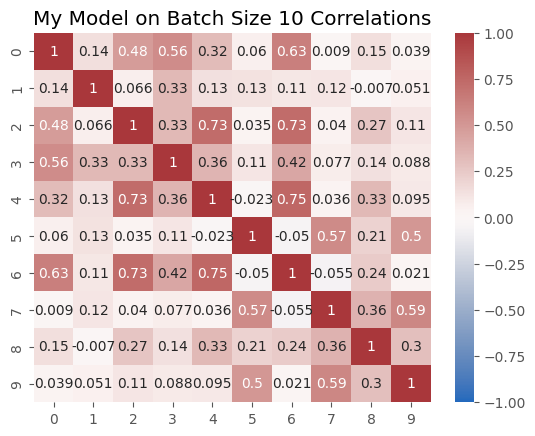

In [ ]:
import pandas as pd
import seaborn as sns
# Create a pandas DataFrame from the correlation matrix
df = pd.DataFrame(correlation_matrix_my)


df.columns = range(10)
df.index = range(10)

sns.heatmap(df.round(3), annot=True, vmin=-1, vmax=1, cmap='vlag')
plt.title('My Model on Batch Size 10 Correlations')

if save == 1:
  path = "/content/drive/MyDrive/NNnotebooks/assignment/models/my model on batch size 10 correlation.jpeg"
  plt.savefig(path)
# Display the DataFrame
print(df)
